This notebook is created to work with augmented UKF for an example system.

Author: Süleyman Fatih Kara

# Constant Turn Rate and Velocity

State vector is given as
$\textbf{x}_k = \left[\begin{matrix}x_k \quad y_k \quad v_k \quad \psi_k \quad \dot{\psi}_k \end{matrix}\right]^T.$

The non-additive dynamic model is provided by $\textbf{x}_{k+1} = f(x_k,q_k)$

$$\textbf{x}_{k+1} = \textbf{x}_k + 
\left[\begin{matrix} 
\frac{v_k}{\dot{\psi_k}}(sin(\psi_k + \dot{\psi}_kT)-sin(\psi_k)) \\
\frac{v_k}{\dot{\psi_k}}(-cos(\psi_k + \dot{\psi}_kT)-cos(\psi_k)) \\
0 \\
\dot{\psi}_k T\\
0
\end{matrix}\right] + 
\left[\begin{matrix} 
\frac{1}{2} T^2 cos(\psi_k) a_{v,k} \\
\frac{1}{2} T^2 sin(\psi_k) a_{v,k} \\
T a_{v,k} \\
\frac{1}{2} T^2 a_{\psi,k} \\
T a_{\psi,k}
\end{matrix}\right] $$

The measuremen model consists of two sensors:
### Radar:
$$
\left[\begin{matrix} 
\rho \\ \phi \\ \dot{\phi}
\end{matrix}\right] = 
\left[\begin{matrix} 
\sqrt{x^2 + y^2} \\
\textit{atan}(y/x) \\
\frac{xv_x + yv_y}{\sqrt{x^2 + y^2}}
\end{matrix}\right] $$

where $v_x = v cos(\psi)$ and $v_x = v sin(\psi)$.

### Lidar:
$$
\left[\begin{matrix} 
x \\ y 
\end{matrix}\right] = 
\left[\begin{matrix} 
1 \quad 0 \quad 0 \quad 0 \quad 0 \\
0 \quad 1 \quad 0 \quad 0 \quad 0 \\
\end{matrix}\right] 
\left[\begin{matrix} 
x \\
y \\
v \\
\psi \\
\dot{\psi}
\end{matrix}\right]$$

The simulation works with Udacity's Self-Driving course's simulated data ("obj_pose-laser-radar-synthetic-input.txt").


In [13]:
# Includes
import math 
import numpy as np
from numpy.linalg import inv
import scipy.io
import scipy.linalg as lin
import matplotlib.pyplot as plt
import csv

In [14]:
# Read the mat file and extract the true trajectory
with open('obj_pose-laser-radar-synthetic-input.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    sensorData = list(reader)
    
Tfinal = len(sensorData)  
nyR  = 3
nyL  = 2  
nx   = 5
nAug = 7
# Process Noises
speedVar = 0.9*0.9
yawrateVar = 0.6*0.6
# Radar Measurement Noises
rhoVar = 0.3*0.3
phiVar = 0.03*0.03
rhoDotVar = 0.3*0.3
RRadar = np.diag([rhoVar,phiVar,rhoDotVar])
# Lidar Measurement Noises
pxVar = 0.15*0.15
pyVar = 0.15*0.15
RLidar = np.diag([pxVar,pyVar])

xTrue = np.zeros((2,Tfinal))
yP = np.zeros((2,Tfinal))

def f(x,dt):
    TRESHOLD = 0.001
    px = x[0,:]
    py = x[1,:]
    speed = x[2,:]
    yaw   = x[3,:]
    yawRate      = x[4,:]
    speedNoise   = x[5,:]
    yawrateNoise = x[6,:]
    xPre = np.zeros((nx,1))
    xPre[2,:] = speed + speedNoise*dt
    xPre[3,:] = yaw + yawRate*dt + 0.5*yawrateNoise*dt*dt
    xPre[4,:] = yawRate + yawrateNoise*dt
    if(abs(yawRate) <= TRESHOLD):
        xPre[0,:] = px + speed*dt*math.cos(yaw) + 0.5*speedNoise*dt*dt*math.cos(yaw)
        xPre[1,:] = py + speed*dt*math.sin(yaw) + 0.5*speedNoise*dt*dt*math.sin(yaw)

    else:
        xPre[0,:] = px + (speed/yawRate)*(math.sin(yaw + yawRate*dt) - math.sin(yaw)) + 0.5*speedNoise*dt*dt*math.cos(yaw)
        xPre[1,:] = py + (speed/yawRate)*(math.cos(yaw) - math.cos(yaw + yawRate*dt)) + 0.5*speedNoise*dt*dt*math.sin(yaw)
    
    return xPre

def hLidar(x):
    
    y = np.zeros((nyL,1))
    y[0] = x[0]
    y[1] = x[1]
    
    return y

def hRadar(x):
    y = np.zeros((nyR,1))
    px = x[0]
    py = x[1]
    v = x[2]
    yaw = x[3]
    vx = math.cos(yaw)*v
    vy = math.sin(yaw)*v
    
    rho = math.sqrt(px*px + py*py)
    phi = math.atan2(py, px)
    rhodot = (px*vx + py*vy)/rho
        
    y[0] = rho
    y[1] = phi
    y[2] = rhodot
    
    return y


    


# UKF Implementation:

In [15]:
def UKFAug(yin):
      
    alpha = 0.001
    beta  = 2
    kappa = 0
    lamb  = (alpha*alpha)*(nAug+kappa)-nAug
    
    nSigma = 2*nAug+1
    
    xSigma = np.zeros((nAug, nSigma))
    xSigmaPre = np.zeros((nx, nSigma))
    wm     = np.zeros((1, nSigma))
    wc     = np.zeros((1, nSigma))
    P      = np.diag([1, 1, 1, 1, 1])
    PAug   = np.zeros((nAug,nAug))
    PAug[0:nx,0:nx] = P
    PAug[nx,nx] = speedVar
    PAug[nx+1,nx+1] = yawrateVar
    xx     = np.zeros((nAug, 1))
    
    x = np.zeros((nx,Tfinal+1))
    xf = np.zeros((nx,Tfinal+1))
    x0 = np.zeros((nx,1))
    xAug = np.zeros((nAug,1))
    xAug[0] = 1
    xAug[1] = 1
    
    for i in range(nSigma):
        wm[:,i] = 1/(2*(nAug+lamb))
        wc[:,i] = 1/(2*(nAug+lamb))

    wm[:,0] = lamb/(lamb+nAug)
    wc[:,0] = wm[:,0] + 1 - alpha*alpha + beta
    tLast = 1477010443000000-50000
    for t in range(Tfinal):
        # print('time=' + repr(t))
        if(sensorData[t][0]=='L'):
            #continue
            h = hLidar
            ny = nyL
            R = RLidar
            yin = np.zeros((ny,1))
            yin = np.array(sensorData[t][1:3]).astype(np.float).reshape(-1,1)
            tCurrent = np.array(sensorData[t][3]).astype(np.float).reshape(-1,1)
            xTrue[:,t] = np.array(sensorData[t][4:6])
            yP[0,t] = yin[0]
            yP[1,t] = yin[1]
            
        elif(sensorData[t][0]=='R'):
            #continue
            h = hRadar
            ny = nyR
            R = RRadar
            yin = np.zeros((ny,1))
            yin = np.array(sensorData[t][1:4]).astype(np.float).reshape(-1,1)
            tCurrent = np.array(sensorData[t][4]).astype(np.float).reshape(-1,1)
            xTrue[:,t] = np.array(sensorData[t][5:7])
        else:
            print('Error')
        
        dt = (tCurrent-tLast)/1000000
      
        
        # Generate Sigma Points and Weights:
        sP = lin.cholesky((nAug+lamb)*PAug)
        for i in range(nAug):
            xSigma[:,[i+1]]      = xAug + sP.T[:,[i]]
            xSigma[:,[i+nAug+1]] = xAug - sP.T[:,[i]]
        
        xSigma[:,[0]] = xAug
    
        # Time Update:
        for i in range(nSigma):
            xSigmaPre[:,[i]] = f(xSigma[:,[i]],dt)

        # Compute Weighted Points:
        xx = np.sum(np.multiply(wm,xSigmaPre),1).reshape(-1,1)
        
        PPre = np.zeros((nx,nx))
        for i in range(nSigma):
            
            xPreDiff = xSigmaPre[:,[i]]-xx
            if xPreDiff[3]>np.pi:
                xPreDiff[3] = xPreDiff[3] - 2*np.pi
            elif xPreDiff[3]<-np.pi:
                xPreDiff[3] = xPreDiff[3] + 2*np.pi
                
            Pdummy = xPreDiff.dot(xPreDiff.T)
            PPre = PPre + np.multiply(wc[:,[i]], Pdummy)

        #print('xSigmaPre=' + repr(xSigmaPre))     
        
        # Generate Updated Sigma Points and Weights:
        ySigma = np.zeros((ny,nSigma))
        # Weight Update:
        for i in range(nSigma):
            ySigma[:,[i]] = h(xSigmaPre[:,[i]]);
        
        #print('ySigma=' + repr(ySigma)) 
        # Compute Weighted Points: 
        S = np.zeros((ny,ny))
        C = np.zeros((nx,ny))
        yk = np.sum(np.multiply(wm,ySigma),1).reshape(-1,1)
        for i in range(nSigma):
            
            yDiff = ySigma[:,[i]]-yk
            if yDiff[1]>np.pi:
                yDiff[1] = yDiff[1] - 2*np.pi
            elif yDiff[1]<-np.pi:
                yDiff[1] = yDiff[1] + 2*np.pi

            Sdummy = (yDiff).dot(yDiff.T) 
            
            xDiff = xSigmaPre[:,[i]]-xx
            if xDiff[3]>np.pi:
                xDiff[3] = xDiff[3] - 2*np.pi
            elif xDiff[3]<-np.pi:
                xDiff[3] = xDiff[3] + 2*np.pi
                
            Cdummy = (xDiff).dot(yDiff.T)
            
            S = S + np.multiply(wc[:,[i]],Sdummy)
            C = C + np.multiply(wc[:,[i]],Cdummy)
                
        S = S + R
        
        K = C.dot(inv(S))
        
        zDiff = yin-yk
        if zDiff[1]>np.pi:
            zDiff[1] = zDiff[1] - 2*np.pi
        elif zDiff[1]<-np.pi:
            zDiff[1] = zDiff[1] + 2*np.pi
        
        xAug[0:nx] = xx + K.dot(zDiff)
        xf[:,[t]] = xAug[0:nx].reshape(-1,1)
        PAug[0:nx,0:nx] = PPre - K.dot(S.dot(K.T))
        tLast = tCurrent
    return xf  #state estimate


<IPython.core.display.Javascript object>


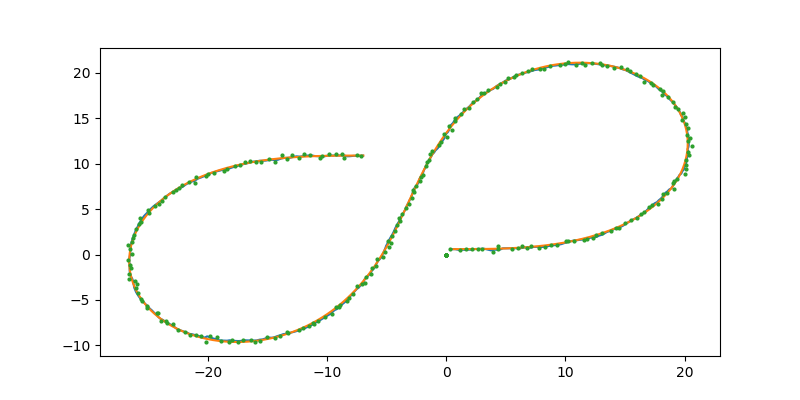

In [16]:
xU = UKFAug(sensorData)
%matplotlib notebook
fig= plt.figure(figsize=(8,4))
plt.plot(xU[0,0:Tfinal],xU[1,0:Tfinal]);
plt.plot(xTrue[0,0:Tfinal],xTrue[1,0:Tfinal])
plt.plot(yP[0,0:Tfinal],yP[1,0:Tfinal],'o',markersize=2)